## **Import Libraries.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##for applyig lemmatization
!pip install -q stanza numpy==1.26.4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import stanza
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout,SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model

 **Load Dataset, Merge Train & Test.**

In [ ]:
dataset = pd.read_excel('/content/Arabic Hate Speech Detection.xlsx')
dataset.head()

,tweet,class
0,!!! RT @mayasolovely: كإمرأة لا يجب أن تشتكي م...,2
1,!!!!! RT @mleew17: يا إلهي، إنه بارد... تايجا ...,1
2,هل سبق لك أن مارست الجنس مع فتاة وبدأت بالبكا...,1
3,!!!!!!!!!! RT @C_G_Anderson: @viva_based تبدو ...,1
4,RT @ShenikaRoberts: الهراء الذي تسمعه عني قد ي...,1


In [ ]:
print(dataset.shape)

(24783, 2)


In [ ]:
print(dataset['class'].value_counts())

class
1    19190
2     4163
0     1430
Name: count, dtype: int64


 ## **Step 1: Remove Punctuations Function**


In [ ]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
other_punctuations = string.punctuation

all_punctuations = arabic_punctuations + other_punctuations
all_punctuations

'`÷×؛<>_()*&^%][ـ،/:"؟.,\'{}~¦+|!”…“–ـ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuation(text):
    text = ''.join(ch for ch in text if ch not in all_punctuations)
    return text

example_text = 'قال الطبيب: "يجب أن تأخذ الدواء ثلاث مرات يوميًا، هل فهمت؟"'
text = remove_punctuation(example_text)
text

'قال الطبيب يجب أن تأخذ الدواء ثلاث مرات يوميًا هل فهمت'

## **Step 2: Remove Diacritics Function**

In [ ]:
def remove_diacritics(tokens):
    arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    return [re.sub(arabic_diacritics, '', token) for token in tokens]

example = ['خَير', 'لِ', 'جَمِيع', 'تَفَوَّت', 'مَقَال', 'رَائِع', 'عَلِم', 'آلَة']

example = remove_diacritics(example)
example

['خير', 'ل', 'جميع', 'تفوت', 'مقال', 'رائع', 'علم', 'آلة']

## **Step 3: Normalize Text Function**

In [ ]:
def normalize(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub("ـ", "", text)
    return text

text = normalize(text)
text

'قال الطبيب يجب ان تاخذ الدواء ثلاث مرات يوميًا هل فهمت'

## **Step 4: Remove Unwanted Characters (URLs, hashtags...)**

In [ ]:
url_re = re.compile(r'https?://\S+|www\.\S+')
username_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')

def remove_unwanted_chars(text):
    text = re.sub(url_re, '', text)
    text = re.sub(username_re, '', text)
    text = re.sub(hashtag_re, '', text)

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

example_text = "‏@Mohamed_Dev صباح الخير للجميع! 🍃 لا تفوّتوا هذا المقال الرائع عن تعلّم الآلة: https://bit.ly/3AIxyz3 #تعلم_الآلة"
text = remove_unwanted_chars(example_text)
text

'صباح الخير للجميع لا تفوتوا هذا المقال الرائع عن تعلم الآلة'

## **Step 5: Remove Stopwords and lemmatize words**

In [ ]:
#download arabic stop words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
arabic_stopwords = stopwords.words('arabic')

In [ ]:
stanza.download('ar')
lemmatize = stanza.Pipeline('ar', processors='tokenize,mwt,pos,lemma')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ar (Arabic) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ar/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
def remove_stopwords(text):
    lemmatized_word = lemmatize(text)
    lemmas = [word.lemma for sentence in lemmatized_word.sentences for word in sentence.words]
    return lemmas

In [ ]:
text = remove_stopwords(text)
text

['صَبَاح',
 'خَير',
 'لِ',
 'جَمِيع',
 'لَا',
 'تَفَوَّت',
 'هٰذَا',
 'مَقَال',
 'رَائِع',
 'عَن',
 'عَلِم',
 'آلَة']

## **Final Preprocessing Function**

In [ ]:
def preprocessing(text):
    text = remove_punctuation(text)
    text = normalize(text)
    text = remove_unwanted_chars(text)
    text = remove_stopwords(text)
    text = remove_diacritics(text)
    return text

## **Testing**

In [ ]:
text = dataset['tweet'][0]
print('text before: ', text)

clean_text = preprocessing(text)
print('text after: ', clean_text)

text before:  !!! RT @mayasolovely: كإمرأة لا يجب أن تشتكي من تنظيف منزلك. وكرجل يجب عليك دائمًا إخراج القمامة...
text after:  ['RT', 'm', 'aya', 'so', 'lovely', 'كامر', 'هو', 'لا', 'وجب', 'أن', 'اشتكى', 'من', 'تنظيف', 'منزلك', 'و', 'كرجل', 'وجب', 'على', 'هو', 'داءم', 'إخراج', 'قمام']


## **Apply function on the dataset**

In [ ]:
dataset['tweet'] = dataset['tweet'].apply(preprocessing)

In [ ]:
dataset.head()

,tweet,class
0,"[RT, m, aya, so, lovely, كامر, هو, لا, وجب, أن...",2
1,"[RT, m, le, e, w17, يا, الهي, أن, هو, بارد, تا...",1
2,"[هل, سبق, لك, أن, مارس, جنس, مع, فتاه, وبدات, ...",1
3,"[RT, CGAn, إe, rson, vivabased, بدا, و, كان, ه...",1
4,"[RT, ShenikaRo, berts, هراء, الذي, سمع, هو, عن...",1


In [ ]:
dataset.to_csv('/content/drive/MyDrive/ANLP|Arabic Hate Speech Detection/dataset.csv', index=False)

## **Importing processed data set**

In [ ]:
dataset = dataset.rename(columns={'tweet': 'Clean_Tweet'})

In [ ]:
dataset = dataset.rename(columns={'class': 'label'})

In [ ]:
dataset['Clean_Tweet'][10]

['كيكس',
 'حقير',
 'هو',
 'أثار',
 'جميع',
 'ههه',
 'دخل',
 'في',
 'محدثة',
 'هو',
 'ك',
 'هٰذا',
 'ههه']

In [ ]:
import ast

def safe_literal_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

dataset['Clean_Tweet'] = dataset['Clean_Tweet'].apply(safe_literal_eval)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset["Clean_Tweet"])

In [ ]:
print("Vocabulary (Word → ID):", tokenizer.word_index)

Vocabulary (Word → ID): {'هو': 1, 'و': 2, 'أن': 3, 'ب': 4, 'من': 5, 'ل': 6, 'في': 7, 'rt': 8, 'على': 9, 'لا': 10, 'عاهر': 11, 'كان': 12, 'هٰذا': 13, 'e': 14, 'يا': 15, 'h': 16, 'عاهرة': 17, 'أي': 18, 'إلى': 19, 'انا': 20, 'r': 21, 'مع': 22, 'ذٰلك': 23, 'تغريد': 24, 'رجل': 25, 'الذي': 26, 'أعاد': 27, 'ما': 28, 'm': 29, 'لقد': 30, 'س': 31, 'فتاه': 32, 'فتاة': 33, 'عن': 34, 'لٰكن': 35, 'd': 36, 'إذا': 37, 'كل': 38, 'عندما': 39, 'شيء': 40, 'جنس': 41, 'ف': 42, 'مثل': 43, 'هل': 44, 'مهبل': 45, 'tt': 46, 'لدى': 47, 'لم': 48, 'قال': 49, 'i': 50, 'n': 51, 'بعض': 52, 'مثلي': 53, 'شخص': 54, 'ليس': 55, 'حصل': 56, 'هءيل': 57, 'a': 58, 'يوم': 59, 'فعل': 60, 'زنوج': 61, 'لأن': 62, 'أمر': 63, 'أو': 64, 'فقط': 65, 'p': 66, 't': 67, 'o': 68, 'ماذا': 69, 'آخر': 70, 'أمكن': 71, 'صغير': 72, 'y': 73, 'حتي': 74, 'غايه': 75, 'جميع': 76, 'أراد': 77, 'أحب': 78, 'l': 79, 'آن': 80, 'اعتقد': 81, 'وجب': 82, 'هذا': 83, 'مارس': 84, 'جد': 85, 'بدا': 86, 'لول': 87, 'تحدث': 88, 'هءلاء': 89, 'لعب': 90, '8220': 91, 'لن': 

In [ ]:
n = 20
first_n_words = dict(list(tokenizer.word_index.items())[:n])
print("First", n, "words:", first_n_words)

First 20 words: {'هو': 1, 'و': 2, 'أن': 3, 'ب': 4, 'من': 5, 'ل': 6, 'في': 7, 'rt': 8, 'على': 9, 'لا': 10, 'عاهر': 11, 'كان': 12, 'هٰذا': 13, 'e': 14, 'يا': 15, 'h': 16, 'عاهرة': 17, 'أي': 18, 'إلى': 19, 'انا': 20}


## **Convert each list of tokens to sequence of IDs**

In [ ]:
train_sequences = tokenizer.texts_to_sequences(dataset['Clean_Tweet'])

In [ ]:
print(train_sequences[4])

[8, 16937, 10757, 165, 26, 396, 1, 211, 114, 12, 289, 64, 114, 12, 122, 10758, 5, 11, 1, 26, 234, 1, 4, 1]


## **Apply padding on each sequence to be of the same size**

In [ ]:
dataset['num_tokens'] = dataset['Clean_Tweet'].apply(len)

print(dataset['num_tokens'].describe())
percentile_95 = dataset['num_tokens'].quantile(0.99)
print(f"95th percentile token count: {int(percentile_95)}")

count    24783.000000
mean        17.348061
std          8.507227
min          1.000000
25%         10.000000
50%         17.000000
75%         24.000000
max         82.000000
Name: num_tokens, dtype: float64
95th percentile token count: 37


In [ ]:
count_over_70 = (dataset['num_tokens'] > 50).sum()
print("Number of rows with more than 70 tokens:", count_over_70)

Number of rows with more than 70 tokens: 3


In [ ]:
dataset.head()

,Clean_Tweet,label,num_tokens
0,"[RT, m, aya, so, lovely, كامر, هو, لا, وجب, أن...",2,22
1,"[RT, m, le, e, w17, يا, الهي, أن, هو, بارد, تا...",1,24
2,"[هل, سبق, لك, أن, مارس, جنس, مع, فتاه, وبدات, ...",1,17
3,"[RT, CGAn, إe, rson, vivabased, بدا, و, كان, ه...",1,12
4,"[RT, ShenikaRo, berts, هراء, الذي, سمع, هو, عن...",1,24


In [ ]:
train_padded = pad_sequences(train_sequences,maxlen=50, padding='post', truncating="post")

In [ ]:
print(train_padded[50])

[ 244   10 6490    4   13   61    2   38   13   17    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## **Apply one hot encoding on label column**

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

label = encoder.fit_transform(dataset[['label']])

In [ ]:
label

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
#compute class weights
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 5.797076023391813, 1: 0.4303077657681122, 2: 1.9857772435897436}

## **Train, validation, test split (80, 10, 10)**

In [ ]:
print(label.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    train_padded,
    label,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
    shuffle=True
)

print(f"Train: {X_train.shape} \t {y_train.shape} \n Val: {X_val.shape} \t {y_val.shape} \n Test: {X_test.shape} \t {y_test.shape}")

(24783, 3)
Train: (19826, 50) 	 (19826, 3) 
 Val: (2478, 50) 	 (2478, 3) 
 Test: (2479, 50) 	 (2479, 3)


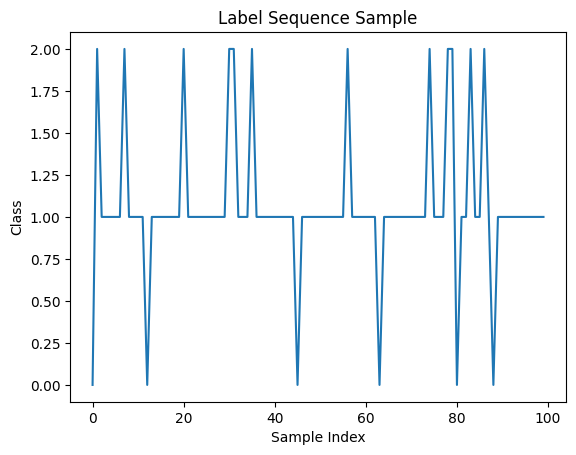

In [ ]:
labels = np.argmax(y_train, axis=1)  # if one-hot encoded

plt.plot(labels[:100])  # plot the first 100 labels
plt.title("Label Sequence Sample")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.show()

 **Modeling on Arabic Data**

In [ ]:
model_bi3 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=100),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(128)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')
])
model_bi3.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint_dir = '/content/drive/MyDrive/ANLP|Arabic Hate Speech Detection/checkpoints'

model_name = 'model_bi3'

checkpoint = ModelCheckpoint(
        os.path.join(checkpoint_dir,f'best_{model_name}.keras'),
        monitor = 'val_accuracy',
        save_best_only = True,
        mode = 'max',
        verbose = 1
    )

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
history_bi3 = model_bi3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.5811 - loss: 1.1907
Epoch 1: val_accuracy improved from -inf to 0.52179, saving model to /content/drive/MyDrive/ANLP|Arabic Hate Speech Detection/checkpoints/best_model_bi3.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 445s 693ms/step - accuracy: 0.5812 - loss: 1.1903 - val_accuracy: 0.5218 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.7942 - loss: 0.5247
Epoch 2: val_accuracy improved from 0.52179 to 0.78733, saving model to /content/drive/MyDrive/ANLP|Arabic Hate Speech Detection/checkpoints/best_model_bi3.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 439s 709ms/step - accuracy: 0.7942 - loss: 0.5247 - val_accuracy: 0.7873 - val_loss: 0.5832 - learning_rate: 0.0010
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.8807 - loss: 0.3014
Epoch 3: val_accuracy did not improve from 0.78733
620/620 ━━━━━━━━━━━━━━━━━━━━ 412s 660ms/step - accuracy: 0.8807 - loss: 0.

In [ ]:
loss, accuracy = model_bi3.evaluate(X_test, y_test)
print(f'Model Accuracy bi1 : {accuracy * 100}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.7984 - loss: 0.5845
Model Accuracy bi1 : 78.98346185684204


In [ ]:
pred_bi3 = np.argmax(model_bi3.predict(X_test), axis = 1)
actual_classes = y_test.argmax(axis=1)
for i in range(5):
    print(f"Sample {i+1}: Predicted = {pred_bi3[i]}, Actual = {actual_classes[i]}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step
Sample 1: Predicted = 1, Actual = 1
Sample 2: Predicted = 1, Actual = 1
Sample 3: Predicted = 2, Actual = 2
Sample 4: Predicted = 2, Actual = 2
Sample 5: Predicted = 1, Actual = 1


In [ ]:
y_test_int = np.argmax(y_test, axis=-1)
print(classification_report(y_test_int, pred_bi3))

              precision    recall  f1-score   support

           0       0.28      0.48      0.35       145
           1       0.93      0.81      0.87      1916
           2       0.60      0.81      0.69       418

    accuracy                           0.79      2479
   macro avg       0.60      0.70      0.64      2479
weighted avg       0.84      0.79      0.81      2479



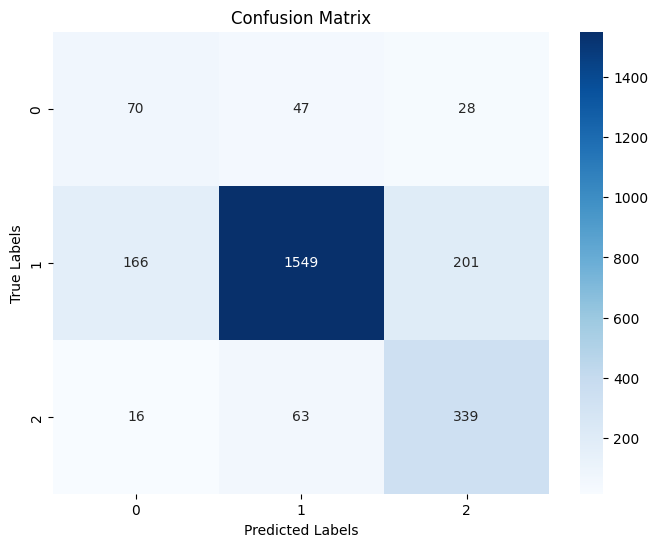

In [ ]:
cm = confusion_matrix(y_test_int, pred_bi3)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## testing
sentence = [
    "حمار كلب أحمق غير مضحك",     # hateful
    "أتمنى لكم يوماً سعيداً مليئاً بالنجاح." ,         #hateless
]

preprocessed_sentences = [preprocessing(s) for s in sentence]

sequences = tokenizer.texts_to_sequences(preprocessed_sentences)

padded_sequences = pad_sequences(sequences, maxlen=100, padding='post')

pred_probs = model_bi3.predict(padded_sequences)
pred_classes = np.argmax(pred_probs, axis=-1)
label_names = encoder.categories_[0]

for i, pred in enumerate(pred_classes):
    pred_label = label_names[pred]
    print(f"Sentence: {sentence[i]}")
    print(f"Predicted class index: {pred}")
    print(f"Predicted label: {pred_label}")
    print('---')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sentence: حمار كلب أحمق غير مضحك
Predicted class index: 1
Predicted label: 1
---
Sentence: أتمنى لكم يوماً سعيداً مليئاً بالنجاح.
Predicted class index: 2
Predicted label: 2
---
